# 1. 프로젝트 목표 및 목적

T P E
- T: 진료내역정보(성별, 나이, 주소, 병명, 병원, 입원일 등) 여러 사항을 고려하여 수진자(서울시) 본인 부담금을 예측한다.
- P : 
- E : 수진자들에 대한 기본정보(성, 연령대, 시도코드 등)와 진료내역(진료과목코드, 주상병코드, 요양일수, 총처방일수 등)으로 구성된 개방데이터건강보험공단에서 제공

# 2. 관련 데이터 수집
- 공공데이터포털 https://data.go.kr/data/15007115/fileData.do 의 2018년 진료 내역 정보(진료내역정보(2018)_20191217.zip)

## 항목별 세부 사항

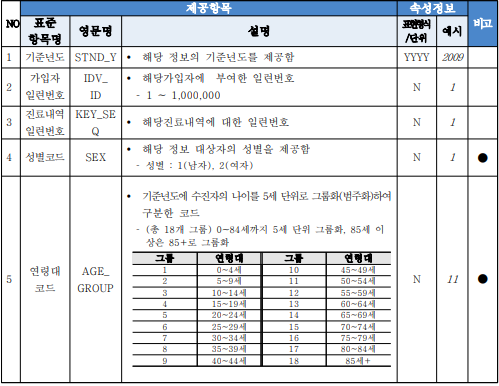

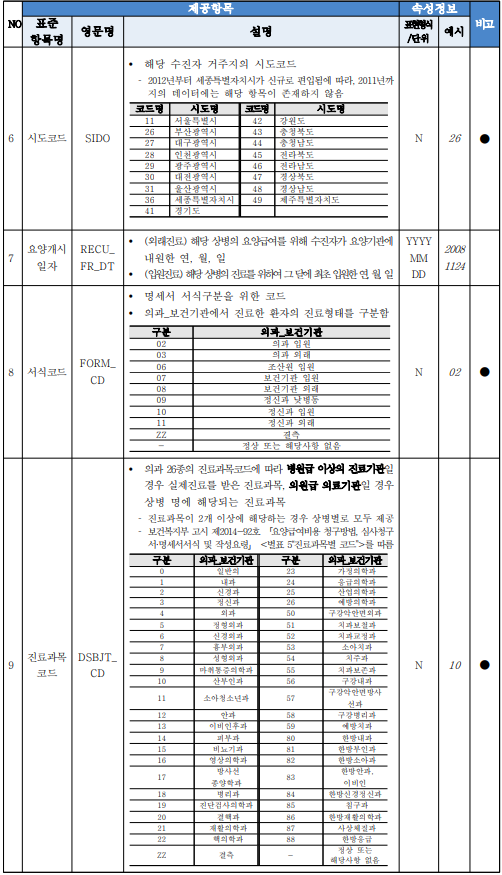

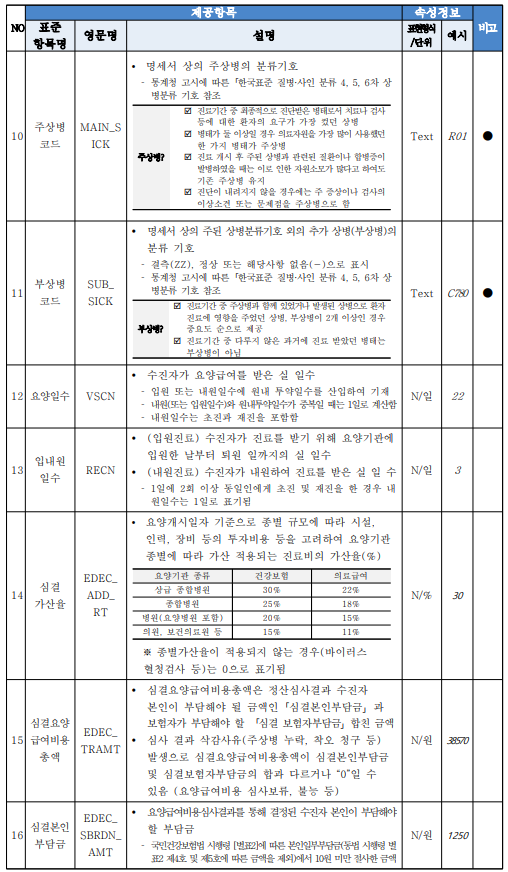

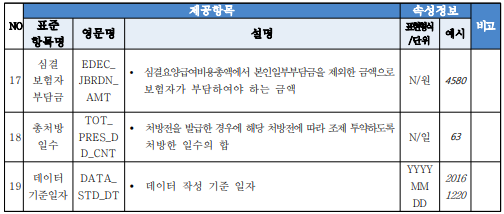

## 사용할 항목(column) 선택

1. 기준 년도 : 제거(2018)
2. 가입자 일련번호 : 제거 -> 같은 사람의 진료라도 개별적인 것으로 처리. 
3. 진료 내역일련번호 : 제거
4. 성별 코드 : **사용**
5. 연령대 코드 : **사용**
6. 시도 코드 : **사용**(서울시만)
7. 요양 개시일 : **미사용**(아프기 시작한 날이므로 날씨, 외부 환경 등에 연관성 있을 수 있다. but 적용 힘들어 일단 제거)
8. 서식 코드 : **사용**(*결측치 제거 필요*. 임의로 대체하기 어려움)
9. 진료 과목 코드 : **사용**(*class*로 바꿔줄 필요가 있다)
10. 주상병 코드 : **사용**(*class*로 바꿔줄 필요가 있다.)
11. 부상병 코드 : 제거 
  - 병이 3개 이상이라면 부상병의 기준을 알 수 없다.
  - 주상병이 영향이 더 클 것 3. one-hot encoding 시에 약 5000개 이상이 추가되어 학습이 잘 이뤄지기 힘들다.
  - 주상병코드 하나만 사용하는 것에 비해 일관성이 떨어질 수 있다는 이유로 제거
12. 요양일수 : **사용**
13. 입내원일수 : **사용**(요양일수와 동일하지 않은 경우도 의외로 존재하기 때문에 둘 다 사용)
14. 심결 가산율 : **사용**(상급 종합 병원(0.3), 종합 병원(0.25), 병원,요양병원(0.2), 의원, 보건의료원(0.15) 등 시설, 인력, 장비 등에 따른 결과값이 나올 것이라고 생각된다. 또한, 0.3, 0.25, 0.2, 0.15가 병원의 등급을 나누는 적절한 기준인지 알 수 없기 때문에 *class*로 바꿔줄 필요가 있다.)
15. 심결 요양 급여비용 총액 : 제거 (심결 요양 급여비용 총액 = 심결 본인 부담금 + 심결 보험자 부담금)
16. 심결 본인 부담금 : **사용**(*결과값*으로 사용)
17. 심결 보험자 부담금 : 제거
18. 총 처방 일수 : **사용**
19. 데이터 기준 일자 : 제거

- 15, 17은 16의 결과값과 직접적으로 연관이 있기 때문에 제거한다.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib의 기본 scheme 대신에 seaborn scheme, font setting
plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

## 데이터셋 가져오기

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
cd /content/gdrive/MyDrive/Colab Notebooks/진료내역정보를 통한 수진자 본인 부담금 예측

/content/gdrive/MyDrive/Colab Notebooks/진료내역정보를 통한 수진자 본인 부담금 예측


In [4]:
col = ['Year', 'ID', 'Key_SEQ', 'Sex', 'Age_Group', 'SIDO', 'Recu_FR_DT', 'FORM_CD', 'DSBJT_CD',
       'Main_Sick', 'Sub_Sick', 'Days', 'RECN', 'EDEC_ADD_RT', 'EDEC_TRAMT', 'EDEC_SBRDN_AMT', 'EDEC_JBRDN_AMT', 'TOT_PRES_DD_CNT', 'dataday']

- 메모리 부족으로 인해 3개의 파일을 모두 사용하는데 어려움이 있었다.
  - 파일 1개(약 455만개 진료 기록)가 충분한 데이터 양이며
  - 서식코드, 진료과목 코드에 결측치가 없어 해당하는 feature로 정렬된 값인가 하여 전체 데이터로 실습해보았으나 data2, data3에도 결측치가 존재하지 않아 편향이 거의 존재하지 않는다고 하여 파일 1개('NHIS_OPEN_T20_2018_PART1.csv')로 진행하였다.

In [5]:
df = pd.read_csv('NHIS_OPEN_T20_2018_PART1.csv', names = col, encoding = 'unicode_escape')

# data2 = pd.read_csv('NHIS_OPEN_T20_2018_PART2.csv', names = col, encoding = 'unicode_escape')
# data3 = pd.read_csv('NHIS_OPEN_T20_2018_PART3.csv', names = col, encoding = 'unicode_escape')

In [6]:
# df = df.append(data2)
# df = df.append(data3)

In [7]:
# del data2
# del data3

In [8]:
df

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
0,±âÁØ³âµµ,°¡ÀÔÀÚÀÏ·Ã¹øÈ£,Áø·á³»¿ªÀÏ·Ã¹øÈ£,¼ºº°ÄÚµå,¿¬·É´ëÄÚµå,½ÃµµÄÚµå,¿ä¾ç°³½ÃÀÏÀÚ,¼­½ÄÄÚµå,Áø·á°ú¸ñÄÚµå,ÁÖ»óº´ÄÚµå,ºÎ»óº´ÄÚµå,¿ä¾çÀÏ¼ö,ÀÔ³»¿øÀÏ¼ö,½É°á°¡»êÀ²,½É°á¿ä¾ç±Þ¿©ºñ¿ëÃÑ¾×,½É°áº»ÀÎºÎ´ã±Ý,½É°áº¸ÇèÀÚºÎ´ã±Ý,ÃÑÃ³¹æÀÏ¼ö,µ¥ÀÌÅÍ±âÁØÀÏÀÚ
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217


## 데이터 확인 및 변경

In [9]:
df.head()

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
0,±âÁØ³âµµ,°¡ÀÔÀÚÀÏ·Ã¹øÈ£,Áø·á³»¿ªÀÏ·Ã¹øÈ£,¼ºº°ÄÚµå,¿¬·É´ëÄÚµå,½ÃµµÄÚµå,¿ä¾ç°³½ÃÀÏÀÚ,¼­½ÄÄÚµå,Áø·á°ú¸ñÄÚµå,ÁÖ»óº´ÄÚµå,ºÎ»óº´ÄÚµå,¿ä¾çÀÏ¼ö,ÀÔ³»¿øÀÏ¼ö,½É°á°¡»êÀ²,½É°á¿ä¾ç±Þ¿©ºñ¿ëÃÑ¾×,½É°áº»ÀÎºÎ´ã±Ý,½É°áº¸ÇèÀÚºÎ´ã±Ý,ÃÑÃ³¹æÀÏ¼ö,µ¥ÀÌÅÍ±âÁØÀÏÀÚ
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217


In [10]:
# 0행 제거
df = df.drop([0])

In [11]:
df.tail()

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217
4550673,2018,350000,7494484,2,12,41,20180312,3,6,M4806,M4316,1,1,0.3,39690,29600,10090,0,20191217


In [12]:
df

,Year,ID,Key_SEQ,Sex,Age_Group,SIDO,Recu_FR_DT,FORM_CD,DSBJT_CD,Main_Sick,Sub_Sick,Days,RECN,EDEC_ADD_RT,EDEC_TRAMT,EDEC_SBRDN_AMT,EDEC_JBRDN_AMT,TOT_PRES_DD_CNT,dataday
1,2018,1,29474228,1,5,47,20181120,03,01,J209,K291,1,1,0.15,21010,6300,14710,3,20191217
2,2018,2,40229620,2,4,28,20180927,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
3,2018,2,26253257,2,4,28,20181204,03,13,J42,J303,1,1,0.15,15310,4500,10810,4,20191217
4,2018,2,42606436,2,4,28,20180807,03,14,L238,K297,1,1,0.15,15310,4500,10810,3,20191217
5,2018,2,31225816,2,4,28,20181002,03,13,J42,J303,1,1,0.15,10950,3200,7750,5,20191217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4550669,2018,350000,43361358,2,12,41,20180723,3,1,M05901,M332,1,1,0.3,55480,5500,49980,102,20191217
4550670,2018,350000,24111380,2,12,41,20181101,3,1,M05901,M332,1,1,0.3,55400,5500,49900,105,20191217
4550671,2018,350000,22899662,2,12,41,20181113,2,24,A099,K297,1,1,0.25,170030,34000,136030,2,20191217
4550672,2018,350000,60142329,2,12,41,20180416,3,1,M05901,M332,1,1,0.3,116440,11600,104840,100,20191217


### 사용하지 않을 Feature 삭제

In [13]:
# df.drop(['Year', 'ID', 'Key_SEQ', 'EDEC_TRAMT', 'EDEC_JBRDN_AMT', 'dataday'], axis = 1, inplace = True)
df.drop(['Year', 'ID', 'Key_SEQ', 'Recu_FR_DT', 'Sub_Sick', 'EDEC_TRAMT', 'EDEC_JBRDN_AMT', 'dataday'], axis = 1, inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550673 entries, 1 to 4550673
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Sex              object
 1   Age_Group        object
 2   SIDO             object
 3   FORM_CD          object
 4   DSBJT_CD         object
 5   Main_Sick        object
 6   Days             object
 7   RECN             object
 8   EDEC_ADD_RT      object
 9   EDEC_SBRDN_AMT   object
 10  TOT_PRES_DD_CNT  object
dtypes: object(11)
memory usage: 416.6+ MB


- Main_Sick, Sub_Sick의 질병 정보 등으로 인해 one-hot encoding 시 데이터 양이 매우 늘어나 학습이 어려울 것이라고 예상되어 **'서울시'** 만 조사.

In [15]:
# SIDO = 11 : 서울시
df = df[df['SIDO'] == 11]

In [16]:
df.reset_index(drop = True, inplace = True)

In [17]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
0,2,8,11,3,1,J209,1,1,0.15,4500,5
1,2,8,11,3,1,J303,1,1,0.15,5100,5
2,1,1,11,3,12,H5222,1,1,0.2,31300,0
3,1,1,11,3,12,H5222,1,1,0.2,11800,0
4,1,1,11,3,12,H5309,1,1,0.15,12000,0
...,...,...,...,...,...,...,...,...,...,...,...
813871,2,18,11,3,1,I109,1,1,0.15,1900,30
813872,2,18,11,3,1,I70990,1,1,0.15,1500,15
813873,2,18,11,3,1,I70990,1,1,0.15,1500,30
813874,2,18,11,3,1,I70990,1,1,0.15,1500,30


### 결측치 제거

- 서식 코드('FORM_CD')의 결측치 'ZZ'는 보건기관을 임의로 정해서 대체하기 어려우며 해당하는 데이터 외에도 정보가 많다고 판단하여 제거
- 진료과목 코드('DSBJT_CD')의 결측치 'ZZ' 또한 진료과목을 임의로 정해서 대체하기 어려우며 해당하는 데이터 외에도 정보가 많다고 판단하여 제거

In [18]:
# 해당 데이터안에는 결측치가 없음
print(df[df['FORM_CD'] == 'ZZ'])
print(df[df['DSBJT_CD'] == 'ZZ'])

Empty DataFrame
Columns: [Sex, Age_Group, SIDO, FORM_CD, DSBJT_CD, Main_Sick, Days, RECN, EDEC_ADD_RT, EDEC_SBRDN_AMT, TOT_PRES_DD_CNT]
Index: []
Empty DataFrame
Columns: [Sex, Age_Group, SIDO, FORM_CD, DSBJT_CD, Main_Sick, Days, RECN, EDEC_ADD_RT, EDEC_SBRDN_AMT, TOT_PRES_DD_CNT]
Index: []


In [19]:
# 결측치가 없으므로 주석 처리
# need_del = df[df['FORM_CD'] == 'ZZ'].index
# df.drop(need_del, axis = 0, inplace = True)
# need_del2 = df[df['DSBJT_CD'] == 'ZZ'].index
# df.drop(need_del2, axis = 0, inplace = True)

### 타입 변환

- 세 항목은 int, float로 하여 서로 독립적으로 판단하지 않아도 된다고 판단하였다.
  - 성별(1, 2)
  - 나이 그룹(0 ~ 85세 이상 -> 1 ~ 18)
  - 심결가산율(상급 종합병원(0.3), 종합병원(0.25), 병원, 요양병원(0.2), 의원, 보건의료원(0.15) : 심결가산율(건강보험공단 기준 인력과 장비의 수준에 따른 진료비 가산율)이 병원의 수준을 적절하게 나타낸다고 가정.



In [20]:
# df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].astype('int')
# df['Age_Group'] = df['Age_Group'].astype('category') 
df['Age_Group'] = df['Age_Group'].astype('int') 
# df['EDEC_ADD_RT'] = df['EDEC_ADD_RT'].astype('category')
df['EDEC_ADD_RT'] = df['EDEC_ADD_RT'].astype('float')

In [21]:
df['Days'] = df['Days'].astype('int')
df['RECN'] = df['RECN'].astype('int')
df['EDEC_SBRDN_AMT'] = df['EDEC_SBRDN_AMT'].astype('int')
df['TOT_PRES_DD_CNT'] = df['EDEC_SBRDN_AMT'].astype('int')

In [22]:
df['FORM_CD'] = df['FORM_CD'].astype('category') 
df['DSBJT_CD'] = df['DSBJT_CD'].astype('category')
df['Main_Sick'] = df['Main_Sick'].astype('category')

In [23]:
FORM_CD = set(df['FORM_CD'])
print(FORM_CD)
print(len(FORM_CD))

DSBJT_CD = set(df['DSBJT_CD'])
print(DSBJT_CD)
print(len(DSBJT_CD))

Main_Sick = set(df['Main_Sick'])
print(Main_Sick)
print(len(Main_Sick))

{8, 2, 3}
3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 50, 55, 80, 85}
30
{'M1997', 'M79140', 'L648', 'M7157', 'E782', 'K871', 'M083', 'I460', 'M6584', 'R1039', 'J9801', 'M6280', 'K868', 'S610', 'H549', 'M4022', 'G211', 'K0769', 'S0291', 'H113', 'K7459', 'S0500', 'H664', 'H16', 'R522', 'J_', 'M6261', 'D329', 'M2586', 'R233', 'H66013', 'K639', 'S82180', 'J948', 'M2454', 'C3490', 'M9901', 'S37307', 'S5318', 'D351', 'M4796', 'H031', 'H1143', 'I443', 'J931', 'E1442', 'M8605', 'R10419', 'M0280', 'P839', 'N281', 'K140', 'S8690', 'H404', 'Z048', 'Z135', 'D414', 'M1049', 'M150', 'E839', 'R208', 'H3559', 'I671', 'I472', 'B0050', 'Z489', 'E835', 'K7410', 'S2233', 'S62530', 'M2558', 'M5322', 'E358', 'I483', 'H66002', 'T2429', 'M2564', 'S0148', 'H6640', 'R430', 'J353', 'M7181', 'L240', 'S7319', 'H748', 'E1022', 'M310', 'K7412', 'M930', 'T813', 'M8285', 'H108', 'M72970', 'H906', 'M0136', 'Z753', 'H271', 'S337', 'M7083', 'H058', 'K222', 'M2390', 'P

### 충분한 데이터가 있는 병(Main_Sick)만 사용
- Main_Sick 의 종류가 너무 많아서(5191개) 데이터 내에 각 병명의 총 개수가 1000개 이하로 소수의 ourlier에 크게 영향을 받을 수 있는 병명은 제외한다. 
  - 즉, exist 리스트에 존재하는 병명만 남긴다. (총 5191개의 병 중에서 **127개**의 병이 남고 전체 진료 데이터의 **약 64%**가 남게 된다.)

In [24]:
sick = list(Main_Sick)

In [25]:
exist = []

In [26]:
for i in range(len(sick)):
  if len(df[df['Main_Sick'] == sick[i]]) > 1000:
    exist.append(sick[i])

In [27]:
len(exist)

127

In [28]:
# df = df[df['Main_Sick'] in exist]
data = pd.DataFrame()
data = data.append(df[df['Main_Sick'] == exist[0]])
for i in range(1, len(exist)):
  data = data.append(df[df['Main_Sick'] == exist[i]])
df = data
del data

In [29]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
567,2,16,11,3,1,E782,1,1,0.15,1000,1000
3135,1,14,11,3,1,E782,1,1,0.15,1800,1800
3344,1,13,11,3,1,E782,1,1,0.15,3200,3200
3345,1,13,11,3,1,E782,1,1,0.15,3200,3200
3346,1,13,11,3,1,E782,1,1,0.15,3200,3200
...,...,...,...,...,...,...,...,...,...,...,...
810525,2,1,11,3,13,J328,1,1,0.15,2900,2900
811971,2,5,11,3,13,J328,1,1,0.15,4500,4500
812228,2,1,11,3,13,J328,1,1,0.15,3500,3500
812231,2,1,11,3,13,J328,1,1,0.15,2500,2500


In [30]:
df.reset_index(drop = True, inplace = True)

In [31]:
df

,Sex,Age_Group,SIDO,FORM_CD,DSBJT_CD,Main_Sick,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
0,2,16,11,3,1,E782,1,1,0.15,1000,1000
1,1,14,11,3,1,E782,1,1,0.15,1800,1800
2,1,13,11,3,1,E782,1,1,0.15,3200,3200
3,1,13,11,3,1,E782,1,1,0.15,3200,3200
4,1,13,11,3,1,E782,1,1,0.15,3200,3200
...,...,...,...,...,...,...,...,...,...,...,...
523659,2,1,11,3,13,J328,1,1,0.15,2900,2900
523660,2,5,11,3,13,J328,1,1,0.15,4500,4500
523661,2,1,11,3,13,J328,1,1,0.15,3500,3500
523662,2,1,11,3,13,J328,1,1,0.15,2500,2500


### One-hot Encoding 적용
- 서식 코드(FORM_CD) # **종류 : 3**
- 진료과목코드(DSBJT_CD) # **종류 : 30**
- 주상병코드(Main_Sick) # **종류 : 127** ( 1000개 이상의 정보가 있는 주상병만 추린 데이터 )

위 세 항목은 각 항목 내 요소끼리의 연관성이 없어 one-hot encoding 적용 필요한 범주형이라고 판단하였다.

- 서식 코드(FORM_CD) One-hot Encoding

- 진료과목코드(FORM_CD) One-hot Encoding

- 주상병코드(Main_Sick) One-hot Encoding

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523664 entries, 0 to 523663
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Sex              523664 non-null  int64   
 1   Age_Group        523664 non-null  int64   
 2   SIDO             523664 non-null  object  
 3   FORM_CD          523664 non-null  category
 4   DSBJT_CD         523664 non-null  category
 5   Main_Sick        523664 non-null  category
 6   Days             523664 non-null  int64   
 7   RECN             523664 non-null  int64   
 8   EDEC_ADD_RT      523664 non-null  float64 
 9   EDEC_SBRDN_AMT   523664 non-null  int64   
 10  TOT_PRES_DD_CNT  523664 non-null  int64   
dtypes: category(3), float64(1), int64(6), object(1)
memory usage: 34.2+ MB


In [33]:
df.describe()

,Sex,Age_Group,Days,RECN,EDEC_ADD_RT,EDEC_SBRDN_AMT,TOT_PRES_DD_CNT
count,523664.000000,523664.000000,523664.000000,523664.000000,523664.000000,5.236640e+05,5.236640e+05
mean,1.591221,9.593824,1.099566,1.772839,0.163936,1.159353e+04,1.159353e+04
std,0.491609,4.934982,1.538462,5.149641,0.038876,5.113980e+04,5.113980e+04
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,6.000000,1.000000,1.000000,0.150000,2.900000e+03,2.900000e+03
50%,2.000000,10.000000,1.000000,1.000000,0.150000,4.500000e+03,4.500000e+03
75%,2.000000,14.000000,1.000000,1.000000,0.150000,7.200000e+03,7.200000e+03
max,2.000000,18.000000,94.000000,300.000000,0.300000,4.839680e+06,4.839680e+06


# 3. 데이터 전처리

- 그래프로 나타내기
  - Feature Importance
  - 병에 따른 본인 부담금
  - 성별에 따른 본인 부담금
  - 나이에 따른 본인 부담금
  - 연령에 따른 본인 부담금
  - 진료과목에 따른 본인부담금
  - 심결 가산율 -> 병원의 수준에 따른 본인 부담금
  - 요양일수에 따른 본인부담금
  - 입내원일수에 따른 본인부담금


# 4. 머신러닝을 위한 데이터 전처리

In [34]:
# Train/Test split
from sklearn.model_selection import train_test_split
# 본인 부담금 : cost
cost = df['EDEC_SBRDN_AMT']
df.drop('EDEC_SBRDN_AMT', axis = 1, inplace = True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523664 entries, 0 to 523663
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Sex              523664 non-null  int64   
 1   Age_Group        523664 non-null  int64   
 2   SIDO             523664 non-null  object  
 3   FORM_CD          523664 non-null  category
 4   DSBJT_CD         523664 non-null  category
 5   Main_Sick        523664 non-null  category
 6   Days             523664 non-null  int64   
 7   RECN             523664 non-null  int64   
 8   EDEC_ADD_RT      523664 non-null  float64 
 9   TOT_PRES_DD_CNT  523664 non-null  int64   
dtypes: category(3), float64(1), int64(5), object(1)
memory usage: 30.2+ MB


In [36]:
# Train에 필요한 Data가 충분하다고 판단하여 95 : 5로 나누었다. 이후에 Train/Test 조정해서 성능 향상을 도모할 수도 있다.
X_train, X_test, y_train, y_test = train_test_split(df, cost, test_size = 0.05, random_state = 42)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(497480, 10) (26184, 10) (497480,) (26184,)


# 5. 학습

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

ValueError: ignored

# 6. 평가 및 튜닝